In [2]:
library(stringr)
library(dplyr)
library(ggplot2)
library(lubridate)
library(ISOweek)
library(scales)
library(zoo)
library(tidyr)
library(quantreg)
library(splines)
library(pbs)
library(forecast)
require(RcppRoll)
library(fpp2)
library(xts)
theme_set(theme_bw())
get_percentage = function(x) {
    (exp(x) - 1) * 100
}


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: SparseM


Attaching package: ‘SparseM’


The following object is masked from ‘package:base’:

    backsolve


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: RcppRoll

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘RcppRoll’”
── Attaching packages ────────────────────────────────────────────── fpp2 2.4 ──

✔ fma       2.4     ✔ expsmooth 2.3




Attaching package: ‘xt

In [3]:
# You can also redownload the data with the get_data.r script
# The data seems to be
df = read.csv("../data/stmf.csv", skip=1)
n_rows = nrow(df)

In [4]:
df["Weekday"] = "1"
df$Week = str_pad(df$Week, 2, pad="0")
data = df %>% unite(Weekdate, "Year", "Week", sep="-W", remove=FALSE)
data = data %>% unite(Weekdate, "Weekdate", "Weekday", sep="-")
data$Date = ISOweek2date(data$Weekdate)
death_cols = c("D0_14", "D15_64", "D65_74", "D75_84", "D85p")
rate_cols = c("R0_14", "R15_64", "R65_74", "R75_84", "R85p")
base_cols = c("CountryCode", "Weekdate", "Year", "Week", "Sex")
data = data %>% pivot_longer(all_of(c(death_cols, rate_cols)), names_pattern="(.)(.*)", names_to=c("Type", "Age")) %>% pivot_wider(names_from=Type, values_from=value)# data$Pop = data$Deaths / data$Rates
data = rename(data, Deaths = D)
data = rename(data, Rates = R)
data$Pop = data$Deaths / data$Rates

data = data %>% group_by(Age, Sex, CountryCode) %>% fill(Pop, .direction="up")
data$Pop_int = data$Pop
data$Pop_int[data$Week != 52] = NA
data = data[data$Week != 53, ]
data = data %>%
    group_by(Sex, Age, CountryCode) %>%
    arrange(Date) %>%
    mutate(time=seq(1, n())) %>% 
    mutate(Pop_int=approx(time,Pop_int,time)$y) %>%
    fill(Pop_int, .direction="downup") %>%
    select(-time)
data$Rate_norm = data$Deaths / data$Pop_int

# European Standard population numbers
# Get the ESP groups
std_esp_pop = c(1000, 4000, 5500, 5500, 5500, 6000, 6000, 6500, 7000, 
            7000, 7000, 7000, 6500, 6000, 5500, 5000, 4000, 2500, 1500, 800, 200)
esp_group = cut(c(0:100), c(0,1,seq(5,95, 5), 200), right=FALSE)
age = c("0_14", "15_64", "65_74", "75_84", "85p")
esp_pop = c(sum(std_esp_pop[1:4]), sum(std_esp_pop[5:14]), sum(std_esp_pop[15:16]), sum(std_esp_pop[17:18]), sum(std_esp_pop[19:21]))
esp_df = data.frame(Age=age, Esp_pop=esp_pop)
esp_groups = levels(esp_group)
std_esp_df = data.frame(age=esp_groups, esp_pop=std_esp_pop)
data = merge(data, esp_df, by="Age")
data$Deaths_norm = data$Rate_norm * data$Esp_pop
sprintf("Fraction of data missing %.2f", dim(data[data$Deaths_norm==0,])[1] / dim(data)[1])
# With a smoother we are down to 3%. This is managable
# Define functions
weighted_mean = function(x) {
    nas = is.na(x)
    w = c(0.25, 0.5, 0.25)
    if (all(nas)) {
        return(0)
    } else {
        w = w[!nas] / sum(w[!nas])
        return(sum(x[!nas] * w))
    }
}
sprintf("Smoothing...")
data <- data %>% group_by(Age, CountryCode, Sex) %>% arrange(Sex, Age, Date) %>%
       mutate(Sdeaths_norm=rollapply(Deaths_norm, 3, weighted_mean, align='center', fill=NA))
sprintf("Fraction of data missing after smoothing %.2f", dim(data[data$Sdeaths_norm==0,])[1] / dim(data)[1])

data = data %>% fill(Sdeaths_norm, .direction="downup") %>% filter(Sdeaths_norm > 0)

head(data)

[1] "Fraction of data missing 0.02"

[1] "Smoothing..."

[1] "Fraction of data missing after smoothing 0.01"

Age,CountryCode,Weekdate,Year,Week,Sex,DTotal,RTotal,Split,SplitSex,Forecast,Date,Deaths,Rates,Pop,Pop_int,Rate_norm,Esp_pop,Deaths_norm,Sdeaths_norm
<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0_14,FIN,1990-W01-1,1990,01,b,1146,0.01194916,0,0,0,1990-01-01,14,0.0007558188,18522.96,18522.96,0.0007558188,16000,12.093101,9.933619
0_14,FIN,1990-W02-1,1990,02,b,1139,0.01187618,0,0,0,1990-01-08,10,0.0005398706,18522.96,18522.96,0.0005398706,16000,8.637929,9.933619
0_14,FIN,1990-W03-1,1990,03,b,1185,0.01235581,0,0,0,1990-01-15,12,0.0006478447,18522.96,18522.96,0.0006478447,16000,10.365515,8.853877
0_14,FIN,1990-W04-1,1990,04,b,1164,0.01213685,0,0,0,1990-01-22,7,0.0003779094,18522.96,18522.96,0.0003779094,16000,6.046550,7.774136
0_14,FIN,1990-W05-1,1990,05,b,1103,0.01150081,0,0,0,1990-01-29,10,0.0005398706,18522.96,18522.96,0.0005398706,16000,8.637929,8.206033
0_14,FIN,1990-W06-1,1990,06,b,1065,0.01110459,0,0,0,1990-02-05,11,0.0005938576,18522.96,18522.96,0.0005938576,16000,9.501722,7.558188


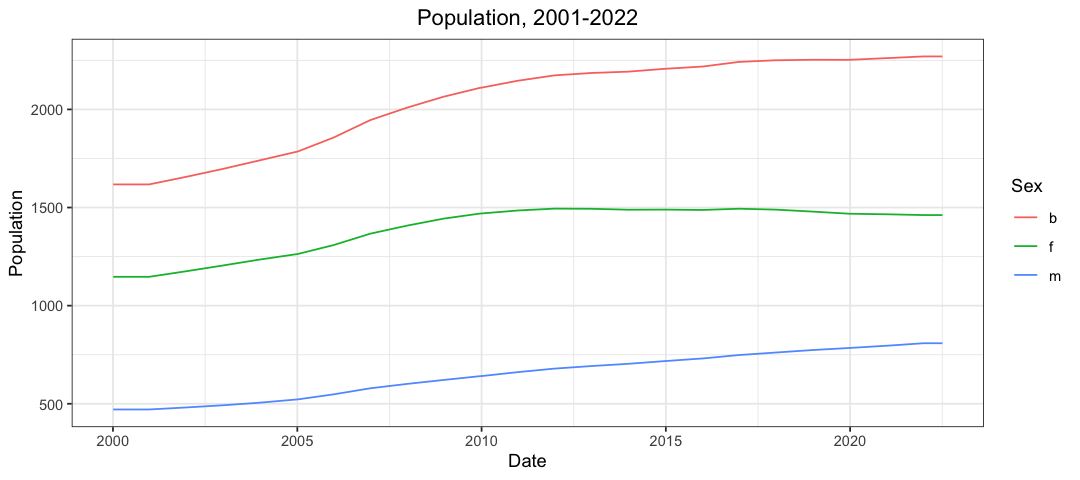

In [5]:
# Debug
# options(repr.plot.width=9, repr.plot.height=4)
# ggplot(subset(data, Age=="85p" & CountryCode=="NOR") %>% group_by(Sex) %>% arrange(Sex, Date), aes(Date, Pop_int, color=Sex)) + geom_line() + 
# labs(x="Date", y="Population", title="Population, 2001-2022", color="Sex") + 
# theme(plot.title=element_text(hjust=.5))

In [13]:
mortality_fit = function(
    data, 
    # Parameters
    years_per_df = 5,
    df.weekly = 7,
    alpha=0.10,
    response.col = "Sdeaths_norm",
    debug=FALSE,
    cv=FALSE) {
    # This function fits trends and confidence intervals at the alpha level
    # Enforced column names in input data
    
    test_start_year = 2020
    start_year = 2012
    
    week.col = "Week"
    year.col = "Year"
    date.col = "Date"
    sex.col = "Sex"
    country.col = "CountryCode"
    age.col = "Age"

    all = data.frame(date = data[,date.col],
                    week = as.numeric(unlist(data[,week.col])),
                    year = as.numeric(unlist(data[,year.col])),
                    response=log(data[, response.col]),
                    sex = as.factor(unlist(data[,sex.col])),
                    country = as.factor(unlist(data[,country.col])),
                    age = as.factor(unlist(data[,age.col])))
    
    colnames(all) = c("date", "week", "year", "response", "sex", "country", "age")
    df.yearly = floor(max((test_start_year - min(all$year)) / years_per_df, 2))
    print(sprintf("Using %d degrees of freedom in yearly splines for %s, %s, %s", 
            df.yearly, all$country[1], all$age[1], all$sex[1]))
    all = subset(all, year(date) > start_year)
    train = subset(all, year(date) < test_start_year)
    test = subset(all, year(date) >= test_start_year)

    yearly.fit = rq(response ~ ns(date, df=df.yearly), data=train)

    train[, "res.yearly"] = yearly.fit$res
    train[, "fit.yearly"] = yearly.fit$fit
    weekly.fit = rq(res.yearly ~ 0 + pbs(week, df=df.weekly), data=train)
    
    train[, "fit.weekly"] = weekly.fit$fit
    train[, "res.weekly"] = weekly.fit$res
    train = train %>% mutate(centered = response - fit.weekly - fit.yearly)
    # Set test date to last train date to fix yearly trend in test period
    mod_date = all$date
    mod_date[year(mod_date) >= test_start_year] = as.Date("2019-12-31", "%Y-%m-%d")
    mod_all = data.frame(date=mod_date, week=all$week)
    all$fit.yearly = predict(yearly.fit, newdata=mod_all)
    all$fit.weekly = predict(weekly.fit, newdata=mod_all)
    
    all = all %>% mutate(centered = response - fit.weekly - fit.yearly)
    n_train = nrow(train)
    n_all = nrow(all)
    # Simple constant quantile c.i.
    fit.low = quantile(train$centered, alpha/2)
    fit.high = quantile(train$centered, 1 - alpha/2)
    train$centered_high = rep(fit.high, n_train)
    train$centered_low = rep(fit.low, n_train)
    all$centered_high = rep(fit.high, n_all)
    all$centered_low = rep(fit.low, n_all)
    
    # Quantile c.i. based on splines
#     fit.low = rq(centered ~ 0 + pbs(week, df=4), data=train, tau=alpha/2)
#     fit.high = rq(centered ~ 0 + pbs(week, df=4), data=train, tau=1-alpha/2)
#     train$centered_high = fit.high$fit
#     train$centered_low = fit.low$fit
#     all$centered_high = predict(fit.high, newdata=all)
#     all$centered_low = predict(fit.low, newdata=all)

    
    test = subset(all, year(date) > 2020)
    frac_outside = sum(train$centered < train$centered_low | train$centered > train$centered_high) / nrow(train)
    frac_outside_test = sum(test$centered < test$centered_low | test$centered > test$centered_high) / nrow(test)
    frac_over_test = sum(test$centered > test$centered_high) / nrow(test)
    if (debug) {
        print(sprintf("Fraction of observations outside confidence band in pre-2020: %.3f", frac_outside))
        print(sprintf("Fraction of observations outside confidence band in 2021: %.3f", frac_outside_test))
        print(sprintf("Fraction of observations over confidence band in 2021: %.3f", frac_over_test))
    }
    if (cv) {
        return(list(df=all, weekly.fit=weekly.fit))
    }
    return(all)
}

plot_debug = function(df) {
    ggplot(df, aes(date, response)) + geom_line(alpha=0.3) + 
    geom_line(aes(date, fit.yearly), size=1.5, color="blue") + 
    geom_line(aes(date, fit.weekly + fit.yearly), size=1.5, color="gold") +
    labs(x="Date", y="Deaths [per 100k per week]", title="Anomalous Mortality 2012-2022") 
}
plot_mortality = function(df) {
    ggplot(df, aes(date, get_percentage(centered))) + geom_line(alpha=0.3) + 
    geom_smooth(method="lm", formula=y ~ ns(x, df=16), se=FALSE) +
    geom_ribbon(aes(ymin=get_percentage(centered_low), ymax=get_percentage(centered_high)), alpha=0.3) + 
    labs(x="Date", y="Deaths [% from baseline 2014-2019]", title="Anomalous Mortality 2012-2022") 

}

In [14]:
stratified = data %>% group_by(CountryCode, Sex, Age) %>% group_map(~ mortality_fit(.x, response.col="Sdeaths_norm"), keep=TRUE)
stratified = do.call(rbind, stratified)

[1] "Using 2 degrees of freedom in yearly splines for AUS, 0_14, b"
[1] "Using 2 degrees of freedom in yearly splines for AUS, 15_64, b"
[1] "Using 2 degrees of freedom in yearly splines for AUS, 65_74, b"
[1] "Using 2 degrees of freedom in yearly splines for AUS, 75_84, b"
[1] "Using 2 degrees of freedom in yearly splines for AUS, 85p, b"
[1] "Using 2 degrees of freedom in yearly splines for AUS, 0_14, f"
[1] "Using 2 degrees of freedom in yearly splines for AUS, 15_64, f"
[1] "Using 2 degrees of freedom in yearly splines for AUS, 65_74, f"
[1] "Using 2 degrees of freedom in yearly splines for AUS, 75_84, f"
[1] "Using 2 degrees of freedom in yearly splines for AUS, 85p, f"
[1] "Using 2 degrees of freedom in yearly splines for AUS, 0_14, m"
[1] "Using 2 degrees of freedom in yearly splines for AUS, 15_64, m"
[1] "Using 2 degrees of freedom in yearly splines for AUS, 65_74, m"
[1] "Using 2 degrees of freedom in yearly splines for AUS, 75_84, m"
[1] "Using 2 degrees of freedom in yearly

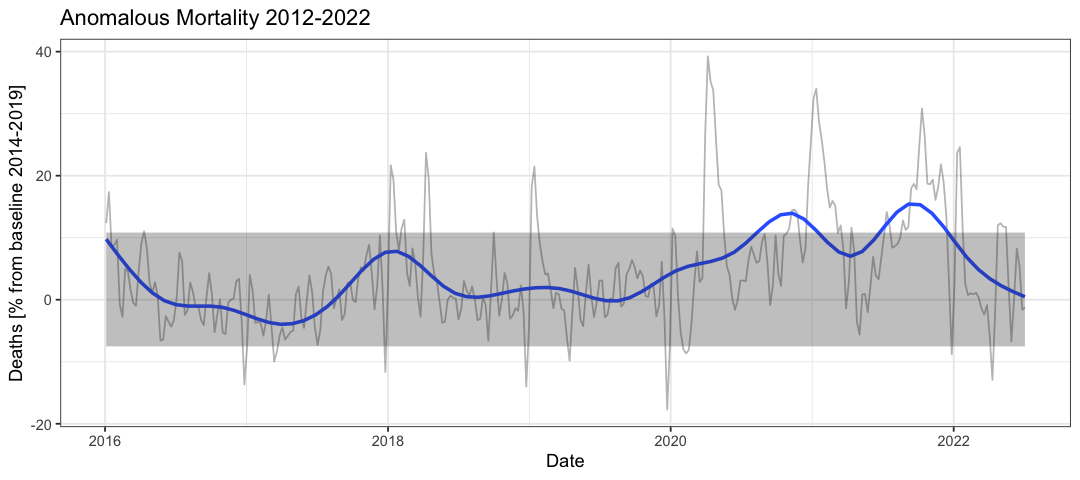

In [28]:
# Subset
options(repr.plot.width=9, repr.plot.height=4)
plot_mortality(subset(stratified, country=="GBR_SCO" & age=="15_64" & sex=="b" & year >= 2016))
# plot_mortality(subset(stratified, country==country & age=="65_74" & sex=="b"))

In [22]:
head(subset(stratified, country=="NOR" & age=="15_64" & sex=="b"))

,date,week,year,response,sex,country,age,fit.yearly,fit.weekly,centered,centered_high,centered_low
,<date>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Sex678268,2013-01-07,2,2013,4.863598,b,NOR,15_64,4.811497,0.04418105,0.007919975,0.1020826,-0.08872462
Sex679268,2013-01-14,3,2013,4.894162,b,NOR,15_64,4.810257,0.04764938,0.036254639,0.1020826,-0.08872462
Sex680268,2013-01-21,4,2013,4.893966,b,NOR,15_64,4.809018,0.04910099,0.035846706,0.1020826,-0.08872462
Sex681277,2013-01-28,5,2013,4.839275,b,NOR,15_64,4.807779,0.04874452,-0.017248854,0.1020826,-0.08872462
Sex682271,2013-02-04,6,2013,4.806540,b,NOR,15_64,4.806540,0.04678861,-0.046788614,0.1020826,-0.08872462
Sex683268,2013-02-11,7,2013,4.828803,b,NOR,15_64,4.805301,0.04344190,-0.019939769,0.1020826,-0.08872462


[1] "Using 4 degrees of freedom in yearly splines for NOR, 65_74, b"


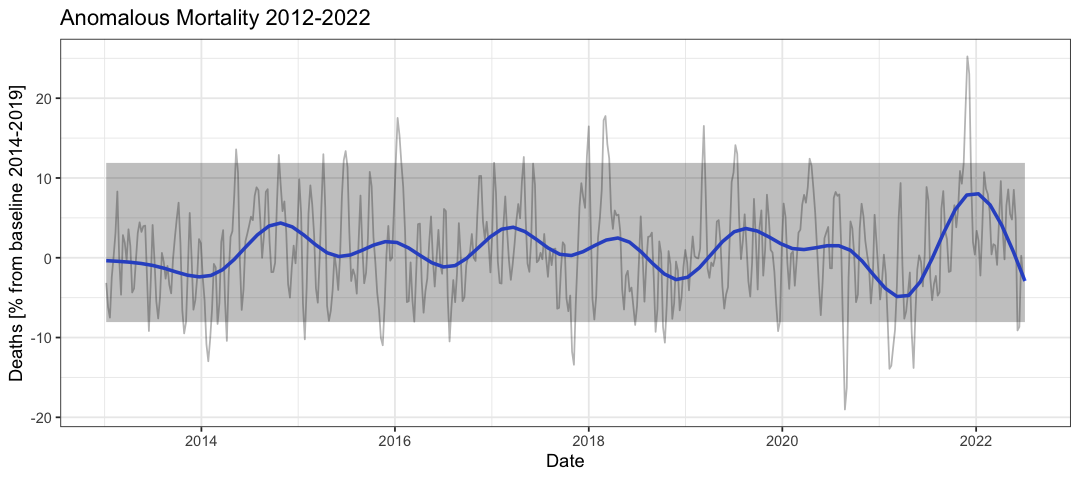

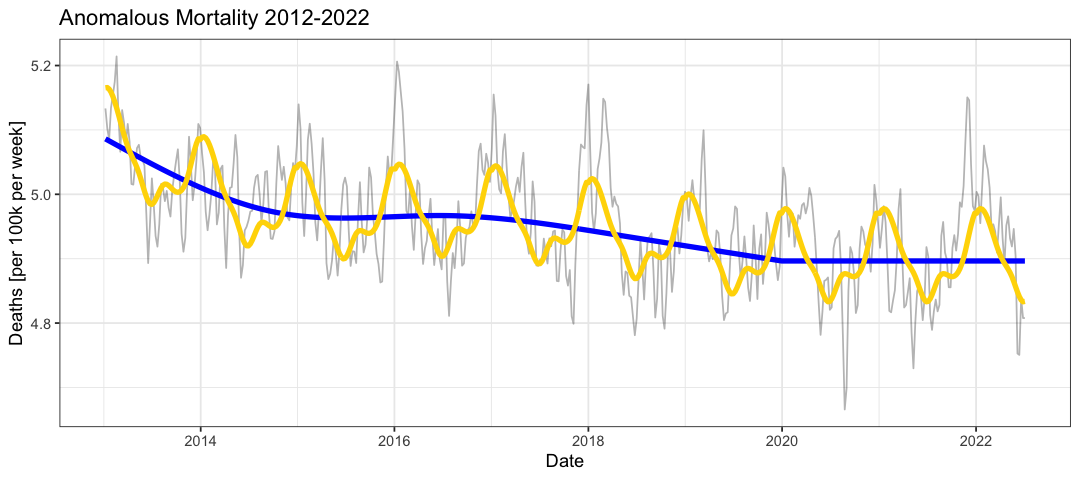

In [16]:
# Subset
options(repr.plot.width=9, repr.plot.height=4)
cdata = subset(data, CountryCode=="NOR" & Age=="65_74" & Sex=="b" & Sdeaths_norm > 0)
all = mortality_fit(cdata, response.col="Sdeaths_norm")
plot_mortality(all)
plot_debug(all)

In [29]:
# Sum age groups' deaths and population
all_ages = subset(data, Age %in% c("65_74", "74_85", "85p")) %>% group_by(Date, CountryCode, Sex) %>% 
    summarise(Sdeaths_norm=sum(Sdeaths_norm),
             Date=Date, Week=Week, Year=Year, Age="all") %>% distinct()
head(all_ages)

`summarise()` has grouped output by 'Date', 'CountryCode', 'Sex'. You can
override using the `.groups` argument.


Date,CountryCode,Sex,Sdeaths_norm,Week,Year,Age
<date>,<chr>,<chr>,<dbl>,<chr>,<int>,<chr>
1990-01-01,FIN,b,964.4409,01,1990,all
1990-01-01,FIN,f,837.9250,01,1990,all
1990-01-01,FIN,m,1242.0091,01,1990,all
1990-01-08,FIN,b,964.4409,02,1990,all
1990-01-08,FIN,f,837.9250,02,1990,all
1990-01-08,FIN,m,1242.0091,02,1990,all


[1] "Using 4 degrees of freedom in yearly splines for NOR, all, b"


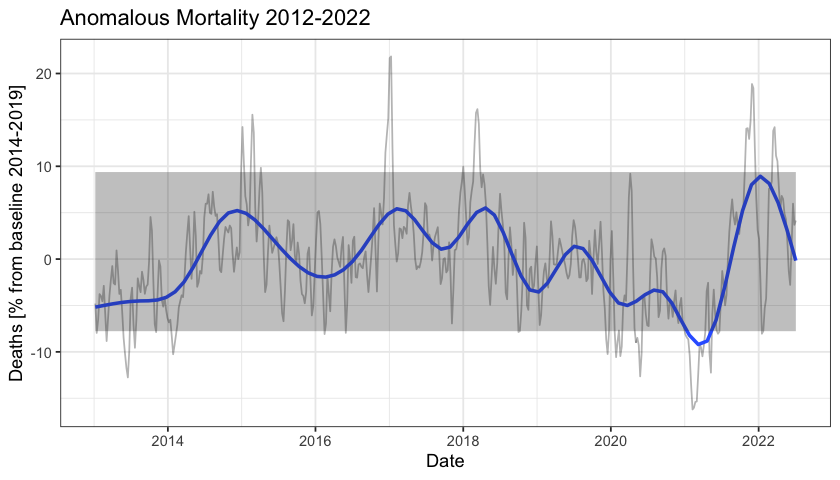

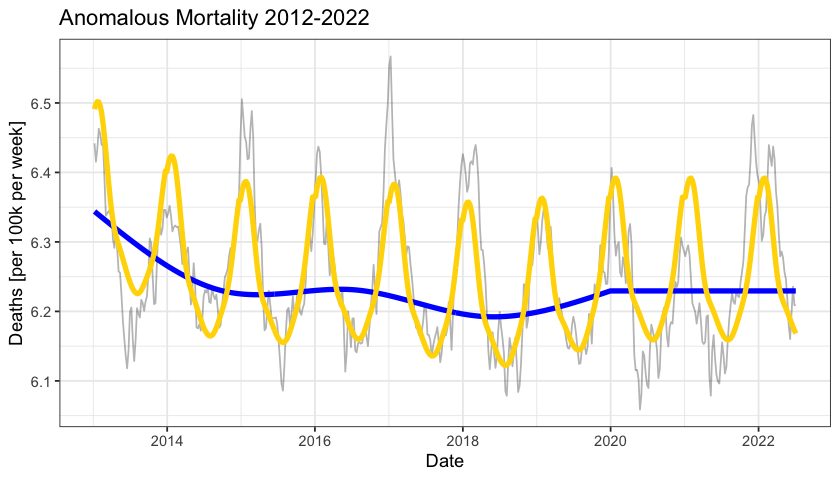

In [32]:
# Fit single country and sex
options(repr.plot.width=7, repr.plot.height=4)
cdata = subset(all_ages, CountryCode=="NOR" & Sex=="b")
all = mortality_fit(cdata)
plot_mortality(all)
plot_debug(all)

In [33]:
# Fit all countries
res = all_ages %>% group_by(CountryCode, Sex) %>% group_map(~ mortality_fit(.x), keep=TRUE)
all_ages_df = do.call(rbind, res)

[1] "Using 2 degrees of freedom in yearly splines for AUS, all, b"
[1] "Using 2 degrees of freedom in yearly splines for AUS, all, f"
[1] "Using 2 degrees of freedom in yearly splines for AUS, all, m"
[1] "Using 4 degrees of freedom in yearly splines for AUT, all, b"
[1] "Using 4 degrees of freedom in yearly splines for AUT, all, f"
[1] "Using 4 degrees of freedom in yearly splines for AUT, all, m"
[1] "Using 4 degrees of freedom in yearly splines for BEL, all, b"
[1] "Using 4 degrees of freedom in yearly splines for BEL, all, f"
[1] "Using 4 degrees of freedom in yearly splines for BEL, all, m"
[1] "Using 4 degrees of freedom in yearly splines for BGR, all, b"
[1] "Using 4 degrees of freedom in yearly splines for BGR, all, f"
[1] "Using 4 degrees of freedom in yearly splines for BGR, all, m"
[1] "Using 2 degrees of freedom in yearly splines for CAN, all, b"
[1] "Using 2 degrees of freedom in yearly splines for CAN, all, f"
[1] "Using 2 degrees of freedom in yearly splines for CAN, all

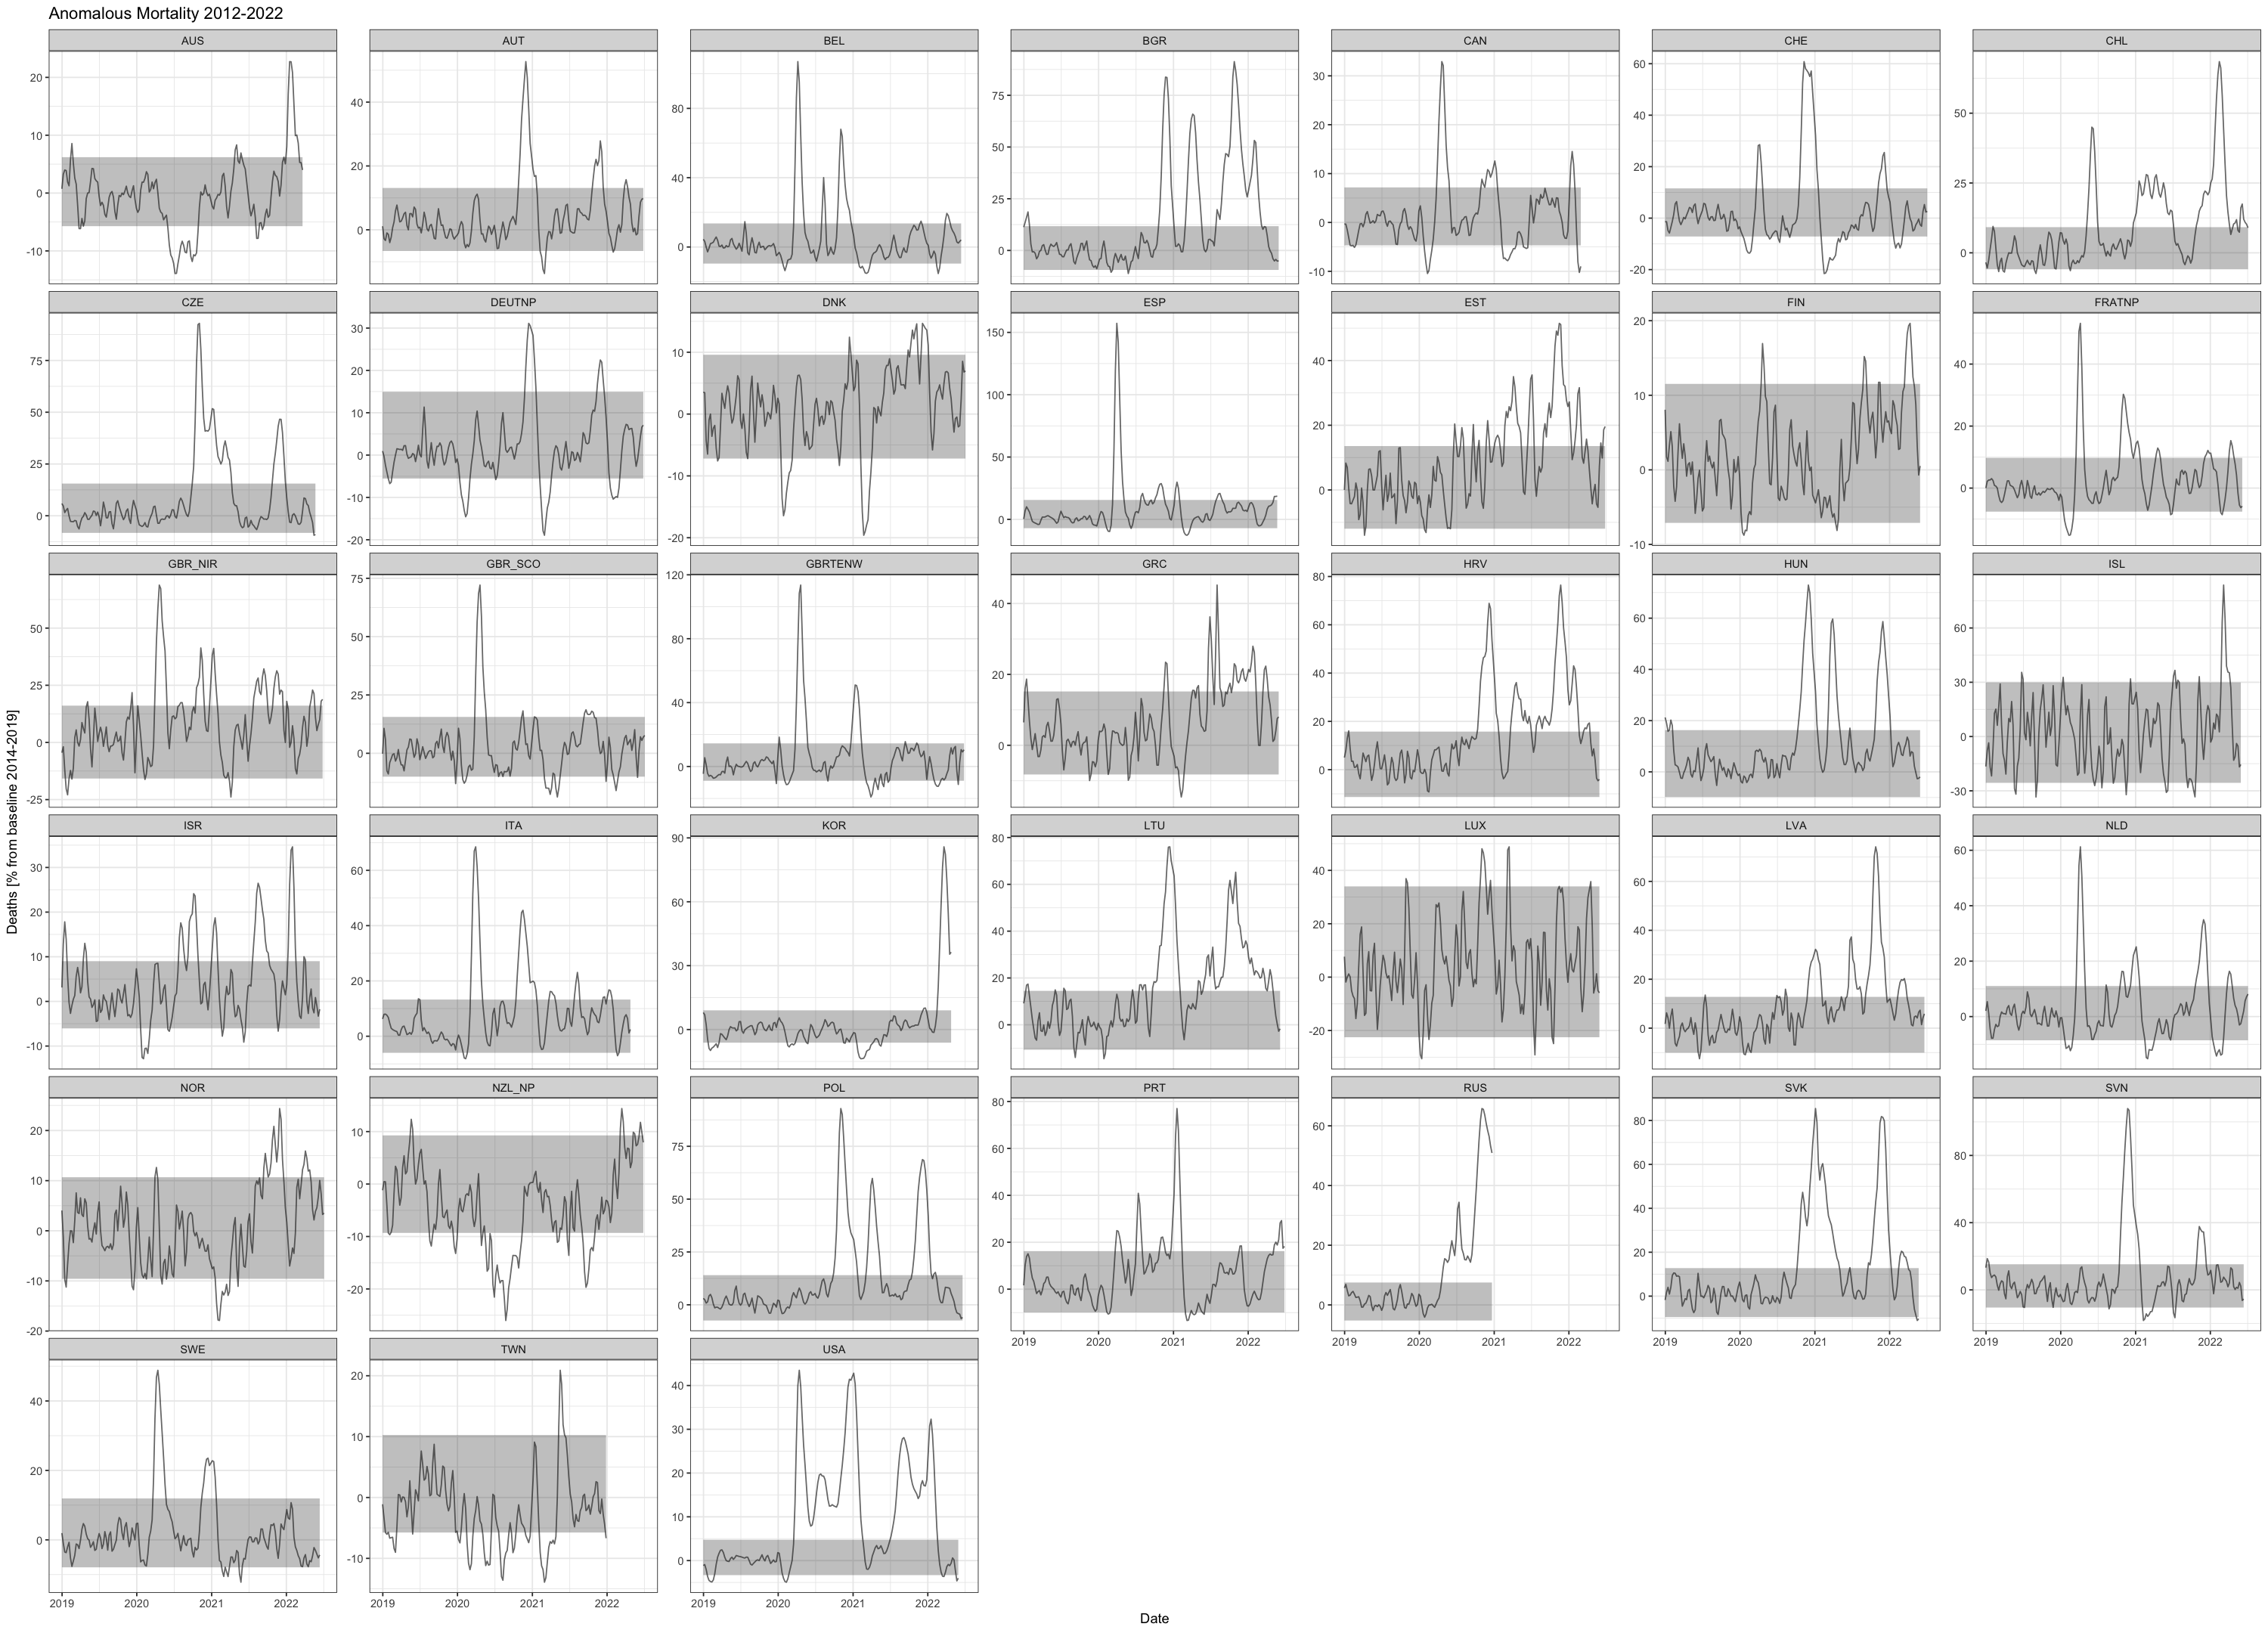

In [34]:
options(repr.plot.width=25, repr.plot.height=18)
p = ggplot(subset(all_ages_df, sex=="f" & year >= 2019), aes(date, get_percentage(centered))) + geom_line(alpha=0.6) + 
# geom_smooth(method="lm", formula=y ~ ns(x, df=16), se=FALSE) +
geom_ribbon(aes(ymin=get_percentage(centered_low), ymax=get_percentage(centered_high)), alpha=0.3) + 
labs(x="Date", y="Deaths [% from baseline 2014-2019]", title="Anomalous Mortality 2012-2022") + 
facet_wrap(~country, scales="free_y")
p
# ggsave(p,file="../figures/all_countries_smooth.pdf", width=14, height=10)

In [89]:
# Cross-validate to find best smoothing parameter by minimizing out-of-sample 
# deviation from estimated exceedence. I.e. for a 95% confidence band, we will expect 
# 5% of out-of-sample estimates to be outside this band. We thus choose the smallest number 
# of parameters that get us there.
# Conclusion: The predictive power is not dependent on degrees of freedom of smoothing
# options(repr.plot.width=7, repr.plot.height=4)
cv_mortality = function(cdata,
                       years_per_df = 5,
                       test_start_year = 2020,
                       cv_weekly=TRUE,
                       cv_res=FALSE,
                       dfs=c(2, 4, 6, 8, 10, 12, 14, 16, 18, 20),
                       df_other=7,
                       response="Sdeaths_norm") {

    # TODO: make df_opther into a vector of same length as dfs
    
    all = cdata %>% rename(week=Week, year=Year, age=Age, date=Date, country=CountryCode, sex=Sex, 
                     response=all_of(response))
    all$week = as.numeric(all$week)
    all$year = as.numeric(all$year)
    
    df.yearly = floor(max((test_start_year - min(all$year)) / years_per_df, 2))
    train = subset(all, year < 2020 & year > 2012)
    alpha = 0.05 # Confidence interval

    years = unique(train$year)
    n_years = length(years)
    n_dfs = length(dfs)
    te_hat = matrix(0, n_years, n_dfs)
    tr_hat = matrix(0, n_years, n_dfs)
    sd_ratio_hat = matrix(0, n_years, n_dfs)
    INFL = 1.
    out = vector(mode="list", length=n_years)
    for (i in 1:n_years) {
        out[[i]] = vector(mode="list", length=n_dfs)
        for (j in 1:n_dfs) {
            m_year = years[i]
            tr = subset(train, year != m_year)
            te = subset(train, year == m_year)
            n_tr = nrow(tr)
            n_te = nrow(te)
            yearly.fit = rq(response ~ ns(date, df=df.yearly), data=tr)

            tr[, "res.yearly"] = yearly.fit$res
            tr[, "fit.yearly"] = yearly.fit$fit

            if (dfs_week[i] <= 2) {
                weekly.fit = rq(res.yearly ~ week, data=tr)
            } else {
                weekly.fit = rq(res.yearly ~ 0 + pbs(week, df=dfs_week[i]), data=tr)
            }

            tr[, "fit.weekly"] = weekly.fit$fit
            tr[, "res.weekly"] = weekly.fit$res
            tr = tr %>% mutate(centered = response - fit.weekly - fit.yearly)
            te$fit.yearly = predict(yearly.fit, newdata=te)
            te$fit.weekly = predict(weekly.fit, newdata=te)

            te = te %>% mutate(centered = response - fit.weekly - fit.yearly)

            if (dfs_res[j] <= 2) {
                fit.low = quantile(tr$centered, alpha/2)
                fit.high = quantile(tr$centered, 1 - alpha/2)      
                tr$high = rep(fit.high, n_tr)
                tr$low = rep(fit.low, n_tr)
                te$high = rep(fit.high, n_te)
                te$low = rep(fit.low, n_te)
            } else {
                fit.low = rq(centered ~ 0 + pbs(week, df=dfs_res[j]), data=tr, tau=alpha/2)
                fit.high = rq(centered ~ 0 + pbs(week, df=dfs_res[j]), data=tr, tau=1-alpha/2)
                tr$high = fit.high$fit
                tr$low = fit.low$fit
                te$high = predict(fit.high, newdata=te)
                te$low = predict(fit.low, newdata=te)
            }
            
            sd_ratio_hat[i, j] = sd(te$centered) / sd(tr$centered)
            tr_hat[i, j] = 1 - (sum(tr$low > tr$centered | tr$high < tr$centered) / nrow(tr))
            te_hat[i, j] = 1 - (sum(te$low > te$centered | te$high < te$centered) / nrow(te))
        }
    }
    te_oos_error = data.frame(mean=apply(te_hat, 2, median), sd=apply(te_hat, 2, sd)/sqrt(n_years), dfs=dfs)
    tr_oos_error = data.frame(mean=apply(tr_hat, 2, median), sd=apply(tr_hat, 2, sd)/sqrt(n_years), dfs=dfs)
    oos_error = rbind(train=tr_oos_error, test=te_oos_error)
    oos_error$data_set = rownames(oos_error)
    oos_error$data_set = gsub("\\.*\\d", "", oos_error$data_set)
    oos_error$sex = all$sex[1]  # all rows in input must be same sex
    oos_error$country = all$country[1]  # all rows in input must be same sex
    return(oos_error)
}

In [90]:
oos_error = cv_mortality(subset(all_ages, CountryCode=="USA" & Sex=="b"))
head(oos_error)

,mean,sd,dfs,data_set,sex,country
,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
train.1,0.9420290,0.003603509,3,train,b,USA
train.2,0.9468599,0.002841063,4,train,b,USA
train.3,0.9468599,0.004388892,6,train,b,USA
train.4,0.9710145,0.004333931,8,train,b,USA
train.5,0.9468599,0.006698545,10,train,b,USA
train.6,0.9661836,0.007694082,12,train,b,USA


In [91]:
cv_all_ages = subset(all_ages, Sex="b") %>% group_by(CountryCode) %>% group_map(~ cv_mortality(.x), keep=TRUE)

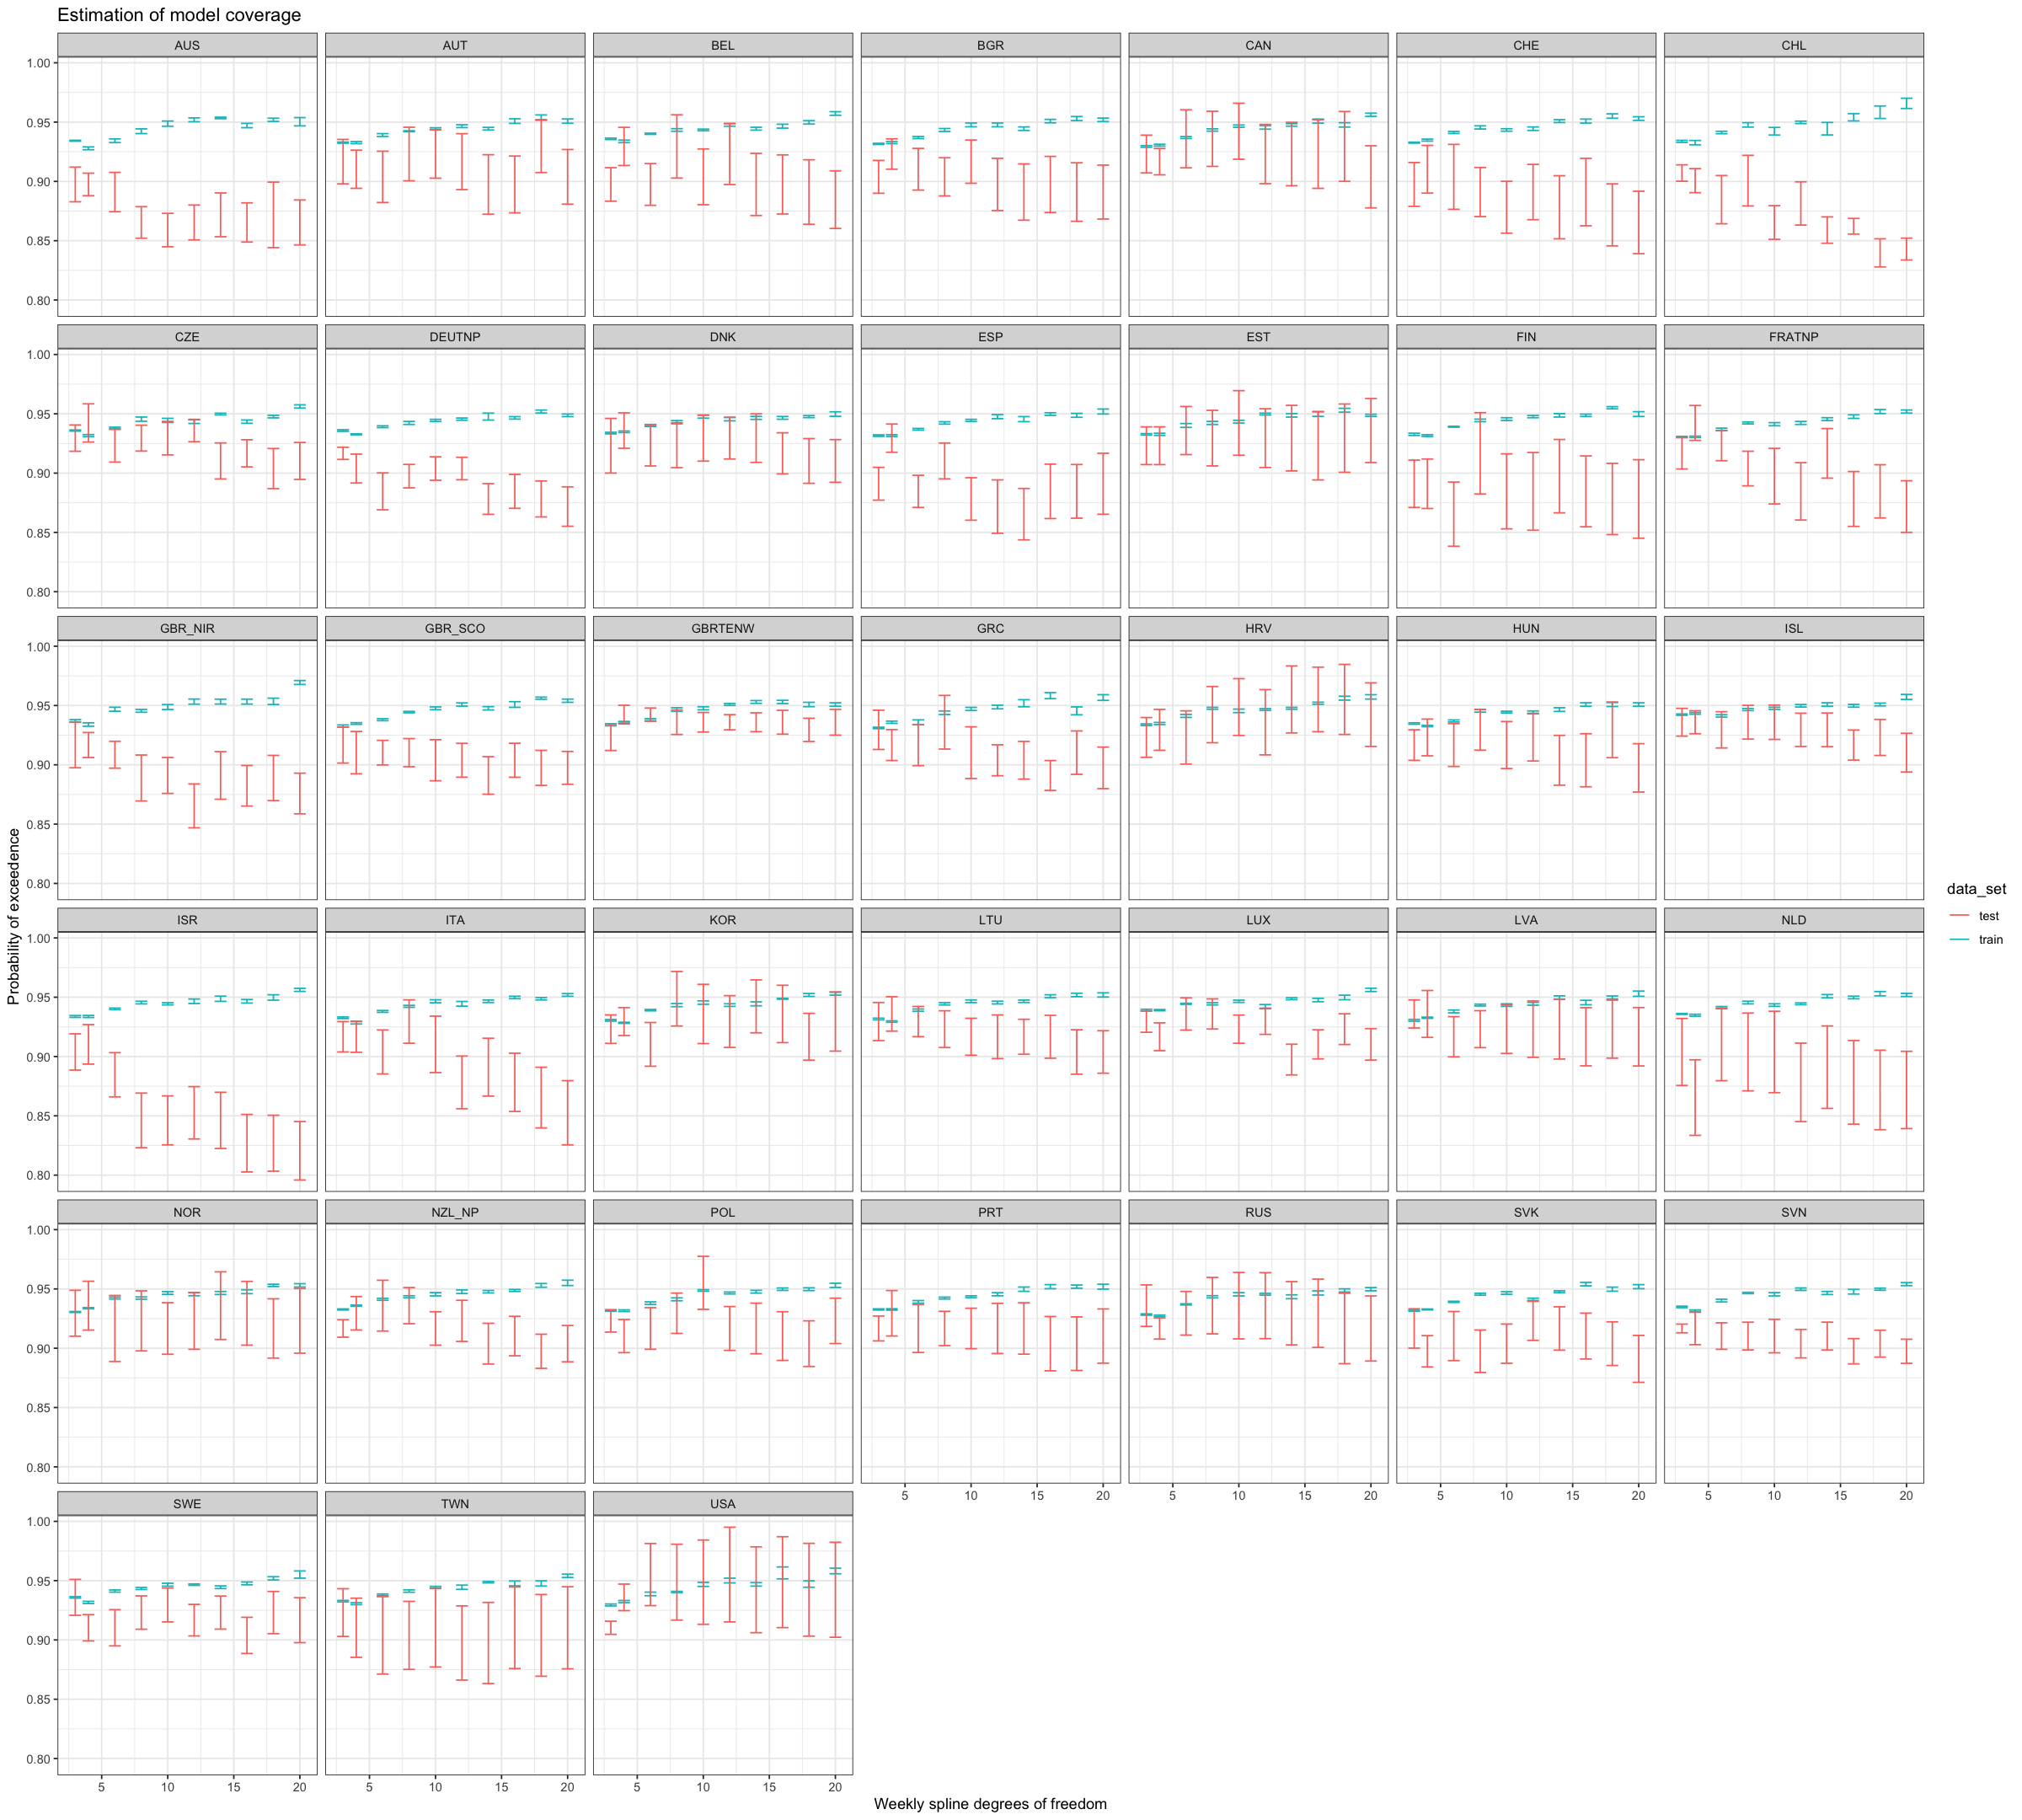

In [92]:
options(repr.plot.width=20, repr.plot.height=18)
p = ggplot(do.call(rbind, cv_all_ages),
      aes(x=dfs, mean, ymin=mean-sd, ymax=mean+sd, color=data_set)) + geom_errorbar() +
    theme_bw() +
    facet_wrap(~country) +
    labs(y="Probability of exceedence", x="Weekly spline degrees of freedom", 
    title="Estimation of model coverage")
p
# ggsave(p, file="../figures/all_countries_cv.pdf", width=20, height=15)

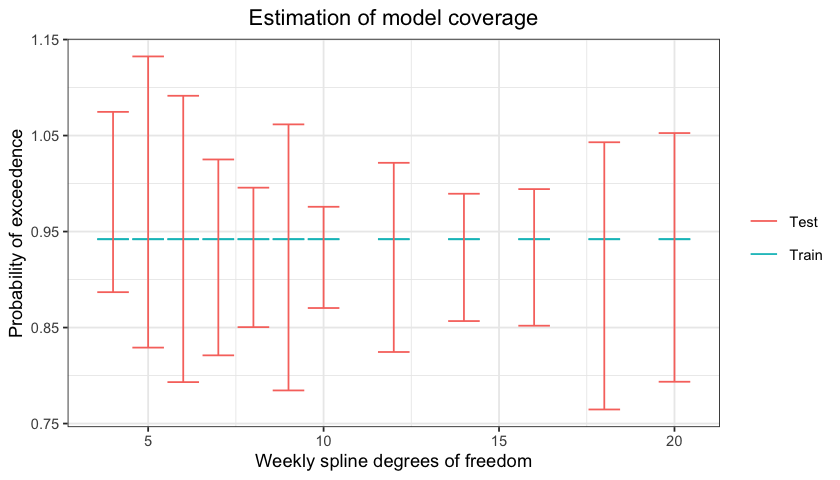

In [45]:
options(repr.plot.width=7, repr.plot.height=4)
ggplot(oos_error, 
       aes(x=dfs, mean, ymin=mean-sd, ymax=mean+sd, color=data_set)) + geom_errorbar() +
theme_bw() +
theme(plot.title=element_text(hjust=.5), 
      legend.key.size=unit(0.7, "cm"),
#      legend.position = c(0.18, 0.15),
     legend.title=element_blank()) + 
labs(y="Probability of exceedence", x="Weekly spline degrees of freedom", 
     title="Estimation of model coverage") +
scale_color_discrete("", labels=c("Test", "Train"))
# ggsave(get_figloc("cv_pois_s2008.pdf"), width=7, height=4)
# ggsave(get_figloc("cv_pois_s2008.png"), width=7, height=4)

[1] "Using 4 degrees of freedom in yearly splines for NOR, all, b"


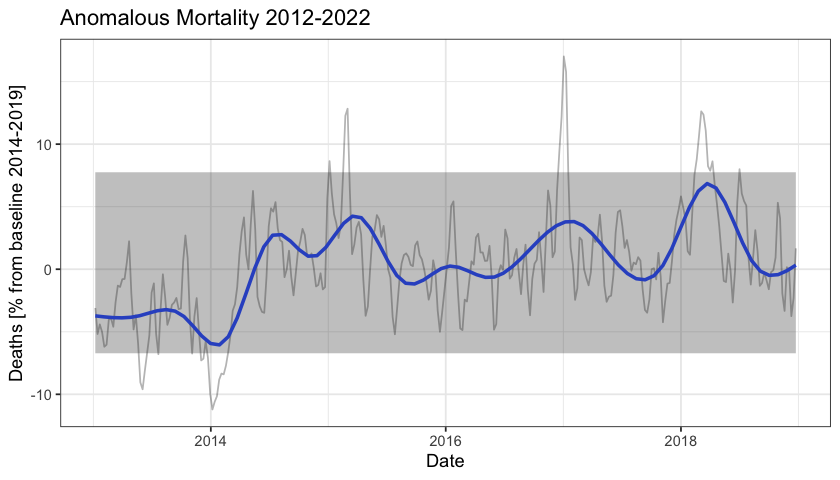

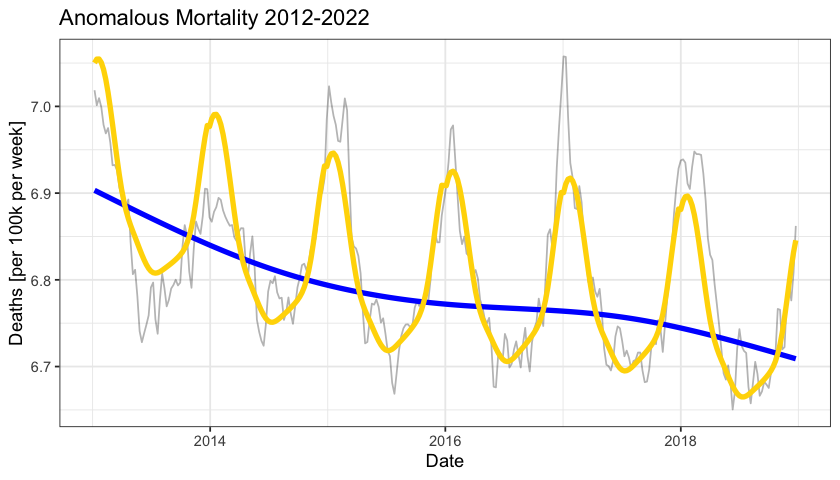

In [86]:
options(repr.plot.width=7, repr.plot.height=4)
tr_res = mortality_fit(tr, cv=TRUE)
tr_fit = tr_res$df 
plot_mortality(tr_fit)
plot_debug(tr_fit)